In [1]:
import os
import pandas as pd
import janitor
from tqdm.notebook import tqdm

from utilities import read_json

# Use this to figure out getting the keys in json
# https://www.youtube.com/watch?v=rWcLDax-VmM&t=3s

# Google console for PyPI data
# https://console.cloud.google.com/marketplace/product/gcp-public-data-pypi/pypi?q=search&referrer=search
# https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=pypi&page=dataset

# Schema here
# https://packaging.python.org/en/latest/guides/analyzing-pypi-package-downloads/#data-schema

pd.set_option('display.max_columns', 100)

output_path = "../output/cache_pypi_downloads_payload"

In [8]:
os.listdir(output_path)[:6]

['2023-05-15_2023-05-16_cake-utils-pkg-poorva278.json',
 '2023-05-15_2023-05-16_readable-number.json',
 '2023-04-24_2023-04-25_karcher-home.json',
 '2023-05-27_2023-05-28_odoo-addon-purchase-stock-tier-validation.json',
 '2023-05-15_2023-05-16_nail.json',
 '2023-05-09_2023-05-10_qtapputils.json']

In [3]:
data_list = []
for filename in tqdm(os.listdir(output_path)):
    if filename.endswith(".json"):
        filename = filename.replace(".json", "")
        date, _, _ = filename.split("_", maxsplit=3)
        
        filepath = os.path.join(output_path, filename)
        data = read_json(filepath)
        downloads = data["rows"][0]["download_count"]
        package = data["args"][-1]
        
        data_list.append([package, date, downloads])
        pass

  0%|          | 0/6006 [00:00<?, ?it/s]

In [4]:
# Read in 100 random sample
df_random_sample = (
    pd.read_csv("../../metrics-timeseries/input/random_sample.csv")
    .assign(slug=lambda df: df["github"].str.replace("https://github.com/", ""))
    .assign(slug=lambda df: df["slug"].apply(lambda x: x[:-1] if x.endswith("/") else x))
    .assign(slug=lambda df: df["slug"].str.lower().str.strip())
    .assign(fileslug=lambda df: df["slug"].str.replace("/", "_"))
    .assign(treated=1)
    # Assign the two types
    .assign(boughtstars=lambda df: (df.index < 25).astype(int))
    .assign(treated2=lambda df: df["boughtstars"] + df["treated"])
)
df_random_sample.head(3)

,pkg,return_code,github_url,homepage,earliest_release,gh_url_check,github,pypi,label,slug,fileslug,treated,boughtstars,treated2
0,bird-ospf-link-db-parser,200.0,https://github.com/Andrew-Dickinson/bird-ospf-...,NaN,2023-04-29T07:23:44,1.0,https://github.com/Andrew-Dickinson/bird-ospf-...,https://pypi.org/project/bird-ospf-link-db-par...,bird-ospf-link-db-parser\r\nhttps://github.com...,andrew-dickinson/bird-ospf-link-db-parser,andrew-dickinson_bird-ospf-link-db-parser,1,1,2
1,asciicli,200.0,https://github.com/mrq-andras/asciicli,https://github.com/mrq-andras/asciicli,2023-04-28T07:22:55,1.0,https://github.com/mrq-andras/asciicli,https://pypi.org/project/asciicli/#history,asciicli\r\nhttps://github.com/mrq-andras/asci...,mrq-andras/asciicli,mrq-andras_asciicli,1,1,2
2,bdpotentiometer,200.0,https://github.com/bond-anton/BDPotentiometer,https://github.com/bond-anton/BDPotentiometer,2023-04-27T06:35:18,1.0,https://github.com/bond-anton/BDPotentiometer,https://pypi.org/project/bdpotentiometer/#history,bdpotentiometer\r\nhttps://github.com/bond-ant...,bond-anton/bdpotentiometer,bond-anton_bdpotentiometer,1,1,2


In [21]:
df = (
    pd.DataFrame(data_list, columns=["pkg", "date", "download_count"])
    .assign(date=lambda df: pd.to_datetime(df["date"]))
    .sort_values(["pkg", "date"], ignore_index=True)
    .assign(tt_downloads=lambda df: df.groupby("pkg")["download_count"].cumsum())
    # Merge to get treatment status
    .merge(
        df_random_sample.select_columns("pkg", "treated", "boughtstars", "treated2"),
        how="left",
        on="pkg",
        validate="m:1",
        indicator=True,
    )    
    .assign(treated=lambda df: df["treated"].fillna(0).apply(int))
    .assign(boughtstars=lambda df: df["boughtstars"].fillna(0).apply(int))
    .assign(treated2=lambda df: df["treated2"].fillna(0).apply(int))
    .assign(date=lambda df: pd.to_datetime(df["date"]))    
)
# Assert that 100 repos are assigned as treated
# assert 100 == len(df.drop_duplicates("fileslug").query("treated==1"))
df

,pkg,date,download_count,tt_downloads,treated,boughtstars,treated2,_merge
0,aamaze,2023-04-24,9,9,0,0,0,left_only
1,aamaze,2023-04-25,0,9,0,0,0,left_only
2,aamaze,2023-04-26,0,9,0,0,0,left_only
3,aamaze,2023-04-27,0,9,0,0,0,left_only
4,aamaze,2023-04-28,0,9,0,0,0,left_only
...,...,...,...,...,...,...,...,...
6001,zoomaker,2023-05-23,10,103,0,0,0,left_only
6002,zoomaker,2023-05-24,7,110,0,0,0,left_only
6003,zoomaker,2023-05-25,2,112,0,0,0,left_only
6004,zoomaker,2023-05-26,0,112,0,0,0,left_only


In [22]:
import cmasher as cmr
import janitor
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(
    context="notebook", font_scale=1.5, style="whitegrid", palette="gray"
)  #  Darkgrid Whitegrid Dark White Ticks

/home/lsys/social_proof_stars/venv/lib/python3.10/site-packages/cmasher/utils.py:859: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mplcm.get_cmap(cmap)
/home/lsys/social_proof_stars/venv/lib/python3.10/site-packages/cmasher/utils.py:1194: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  mplcm.register_cmap(cmap=cmap_mpl)
/home/lsys/social_proof_stars/venv/lib/python3.10/site-packages/cmasher/utils.py:1201: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  mplcm.register_cmap(cmap=cmap_mpl_r)
/home/lsys/social_proof_stars/venv/lib/

/home/lsys/social_proof_stars/venv/lib/python3.10/site-packages/cmasher/utils.py:859: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mplcm.get_cmap(cmap)
/home/lsys/social_proof_stars/venv/lib/python3.10/site-packages/cmasher/utils.py:1194: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  mplcm.register_cmap(cmap=cmap_mpl)
/home/lsys/social_proof_stars/venv/lib/python3.10/site-packages/cmasher/utils.py:1201: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  mplcm.register_cmap(cmap=cmap_mpl_r)
/home/lsys/social_proof_stars/venv/lib/

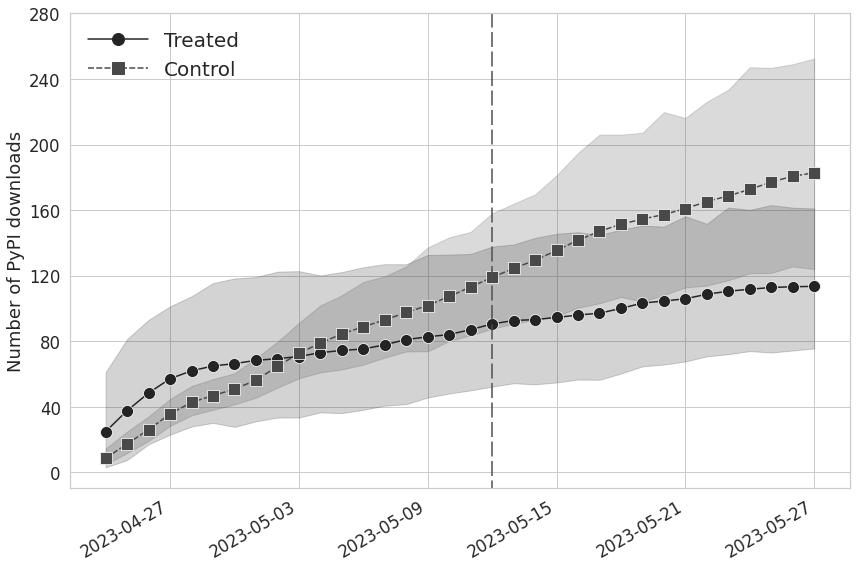

In [25]:
# Treated vs control
_, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(
    data=df,
    x="date",
    y="tt_downloads",
    markersize=12,
    hue="treated",
    style="treated",
    hue_order=[1, 0],
    style_order=[1, 0],
    markers=["o", "s"],
    #     err_style="bars",
    ax=ax,
)

# Set the locator and formatter for the x-axis
myFmt = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(myFmt)

# Specify the desired number of x-axis tickers
ax.xaxis.set_major_locator(plt.MaxNLocator(7))

plt.xticks(rotation=30, ha="right")

# Add a vertical line to annotate a time period
annotate_date = pd.to_datetime("2023-05-12")  # Specify the date to annotate
plt.axvline(x=annotate_date, color=".3", linestyle=(5, (10, 3)))

# # Annotate a text on the plot
# annotate_date = pd.to_datetime('2023-05-15')  # Specify the date to annotate
# annotate_text = 'Annotated Text'  # Specify the text to annotate
# plt.annotate(annotate_text, xy=(annotate_date, 30), xytext=(10, 10),
#              textcoords='offset points', arrowprops=dict(arrowstyle='->'))

ax.set_yticks(range(0, 300, 40))

ax.set_ylabel("Number of PyPI downloads")
ax.set_xlabel("")

# Legend
# get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# specify order of items in legend
order = [0, 1]
labels = ["Treated", "Control"]
ax.legend(
    labels=[labels[idx] for idx in order],
    handles=[handles[idx] for idx in order],
    title="",
    loc="upper left",
    fontsize=20,
    markerscale=2,
    markerfirst=True,
    frameon=False,
    handlelength=3,
)

plt.tight_layout()

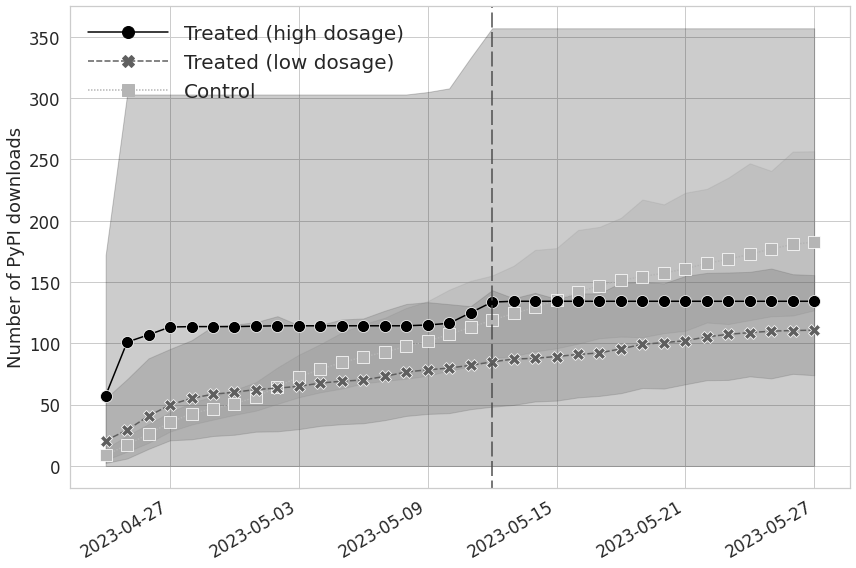

In [28]:
# Treated (by dosage) vs control
_, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(
    data=df,
    x="date",
    y="tt_downloads",
    markersize=12,
    hue="treated2",
    style="treated2",
    hue_order=[2, 1, 0],
    style_order=[2, 1, 0],
    markers=["o", "X", "s"],
    palette=cmr.get_sub_cmap("Greys", 0.4, 1),
    #     err_style="bars",
    ax=ax,
)

# Set the locator and formatter for the x-axis
myFmt = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(myFmt)

# Specify the desired number of x-axis tickers
ax.xaxis.set_major_locator(plt.MaxNLocator(7))

plt.xticks(rotation=30, ha="right")

# Add a vertical line to annotate a time period
annotate_date = pd.to_datetime("2023-05-12")  # Specify the date to annotate
plt.axvline(x=annotate_date, color=".3", linestyle=(5, (10, 3)))

# # Annotate a text on the plot
# annotate_date = pd.to_datetime('2023-05-15')  # Specify the date to annotate
# annotate_text = 'Annotated Text'  # Specify the text to annotate
# plt.annotate(annotate_text, xy=(annotate_date, 30), xytext=(10, 10),
#              textcoords='offset points', arrowprops=dict(arrowstyle='->'))

ax.set_yticks(range(0, 400, 50))

ax.set_ylabel("Number of PyPI downloads")
ax.set_xlabel("")

# Legend
# get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# specify order of items in legend
order = [2, 1, 0]

# add legend to plot
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])

labels = ["Control", "Treated (low dosage)", "Treated (high dosage)"]
ax.legend(
    labels=[labels[idx] for idx in order],
    handles=[handles[idx] for idx in order],
    title="",
    loc="upper left",
    fontsize=20,
    markerscale=2,
    markerfirst=True,
    frameon=False,
    handlelength=4,
)

plt.tight_layout()